In [ ]:
import pandas as pd
import numpy as np

In [44]:
GLOBAL_K_VALUE: int = 5

Load Data Files

In [45]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

In [46]:
# Anime dataset
anime_filtered = load_data('../data/clean/anime-dataset-filtered.csv')

# Recommendation datasets
user_based = load_data('../data/prediction/users-recommendations.csv')
content_based = load_data('../data/prediction/content-recommendations.csv')

# Validation dataset for 2025
watch_shrunk_25 = load_data('../data/clean/users-score-shrunk-2025.csv')

In [47]:
def filter_recommendations(recommendations: pd.DataFrame) -> pd.DataFrame:
    """Filter recommendations to include only valid anime IDs."""
    return recommendations[['anime_id', 'user_id']]

In [48]:
user_based_filtered = filter_recommendations(user_based)
content_based_filtered = filter_recommendations(content_based)

Check for Missing Users

In [49]:
missing_users_user_based = set(user_based['user_id']).difference(set(watch_shrunk_25['user_id']))
missing_users_content_based = set(content_based['user_id']).difference(set(watch_shrunk_25['user_id']))

print(f"Missing users in user-based recommendations: {missing_users_user_based}")
print(f"Missing users in content-based recommendations: {missing_users_content_based}")

Missing users in user-based recommendations: set()
Missing users in content-based recommendations: set()


Metric Functions

In [50]:
def recall_at_k(y_true: np.ndarray, y_scores: np.ndarray, k: int) -> float:
    """Compute recall@k for binary classification."""
    top_k_idx = np.argsort(y_scores)[::-1][:k]
    tp_at_k = y_true[top_k_idx].sum()
    total_positives = y_true.sum()
    return tp_at_k / total_positives

def precision_at_k(y_true: np.ndarray, y_scores: np.ndarray, k: int) -> float:
    """Compute Precision@K for binary classification."""
    top_k_idx = np.argsort(y_scores)[::-1][:k]
    tp_at_k = y_true[top_k_idx].sum()
    return tp_at_k / k

Calculate Quality Metrics

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get all unique anime IDs from recommendations
all_anime_ids = sorted(set(user_based_filtered['anime_id']) | set(content_based_filtered['anime_id']))
anime_id_to_idx = {aid: i for i, aid in enumerate(all_anime_ids)}

# Prepare actual watched anime per user in 2025
actual_watched = watch_shrunk_25.groupby('user_id')['anime_id'].apply(set).to_dict()

# Get common users between recommendations and actual watched
common_users_ub = set(user_based_filtered['user_id']) & set(actual_watched.keys())
common_users_cb = set(content_based_filtered['user_id']) & set(actual_watched.keys())

# Calculate metrics using your functions
ub_recalls = []
ub_precisions = []
cb_recalls = []
cb_precisions = []

# User-based metrics
for user_id in common_users_ub:
    # Get recommendations for this user
    user_recs = user_based_filtered[user_based_filtered['user_id'] == user_id]['anime_id'].values
    
    # Create binary vectors
    y_true = np.array([1 if aid in actual_watched[user_id] else 0 for aid in all_anime_ids])
    y_scores = np.zeros(len(all_anime_ids))
    
    # Assign scores based on recommendation order (higher rank = higher score)
    for rank, anime_id in enumerate(user_recs):
        if anime_id in anime_id_to_idx:
            y_scores[anime_id_to_idx[anime_id]] = len(user_recs) - rank
    
    if y_true.sum() > 0:  # Only calculate if user has watched anime
        ub_recalls.append(recall_at_k(y_true, y_scores, GLOBAL_K_VALUE))
        ub_precisions.append(precision_at_k(y_true, y_scores, GLOBAL_K_VALUE))

# Content-based metrics
for user_id in common_users_cb:
    # Get recommendations for this user
    user_recs = content_based_filtered[content_based_filtered['user_id'] == user_id]['anime_id'].values
    
    # Create binary vectors
    y_true = np.array([1 if aid in actual_watched[user_id] else 0 for aid in all_anime_ids])
    y_scores = np.zeros(len(all_anime_ids))
    
    # Assign scores based on recommendation order
    for rank, anime_id in enumerate(user_recs):
        if anime_id in anime_id_to_idx:
            y_scores[anime_id_to_idx[anime_id]] = len(user_recs) - rank
    
    if y_true.sum() > 0:
        cb_recalls.append(recall_at_k(y_true, y_scores, GLOBAL_K_VALUE))
        cb_precisions.append(precision_at_k(y_true, y_scores, GLOBAL_K_VALUE))

# Calculate averages
avg_ub_recall = np.mean(ub_recalls)
avg_ub_precision = np.mean(ub_precisions)
avg_cb_recall = np.mean(cb_recalls)
avg_cb_precision = np.mean(cb_precisions)

# Calculate hit rates (percentage of users with at least one hit in top-k)
ub_hit_rate = np.mean([1 if p > 0 else 0 for p in ub_precisions])
cb_hit_rate = np.mean([1 if p > 0 else 0 for p in cb_precisions])

# Print results
print(f"Recommendation Performance Metrics @ K={GLOBAL_K_VALUE}\n" + "="*50)
print(f"\nUser-Based Collaborative Filtering:")
print(f"  Recall@{GLOBAL_K_VALUE}:    {avg_ub_recall:.4f}")
print(f"  Precision@{GLOBAL_K_VALUE}: {avg_ub_precision:.4f}")
print(f"  Hit Rate@{GLOBAL_K_VALUE}:  {ub_hit_rate:.4f}")
print(f"  Users evaluated: {len(ub_recalls)}")

print(f"\nContent-Based Filtering:")
print(f"  Recall@{GLOBAL_K_VALUE}:    {avg_cb_recall:.4f}")
print(f"  Precision@{GLOBAL_K_VALUE}: {avg_cb_precision:.4f}")
print(f"  Hit Rate@{GLOBAL_K_VALUE}:  {cb_hit_rate:.4f}")
print(f"  Users evaluated: {len(cb_recalls)}")


Recommendation Performance Metrics @ K=5

User-Based Collaborative Filtering:
  Recall@5:    0.0005
  Precision@5: 0.0364
  Hit Rate@5:  0.1435
  Users evaluated: 10899

Content-Based Filtering:
  Recall@5:    0.0009
  Precision@5: 0.0518
  Hit Rate@5:  0.1875
  Users evaluated: 10942


Calculate Diversity Metrics

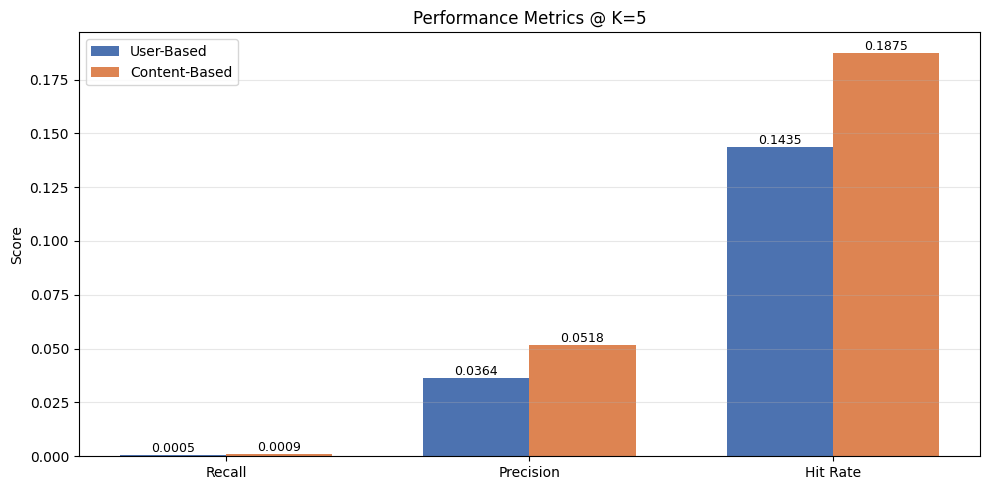

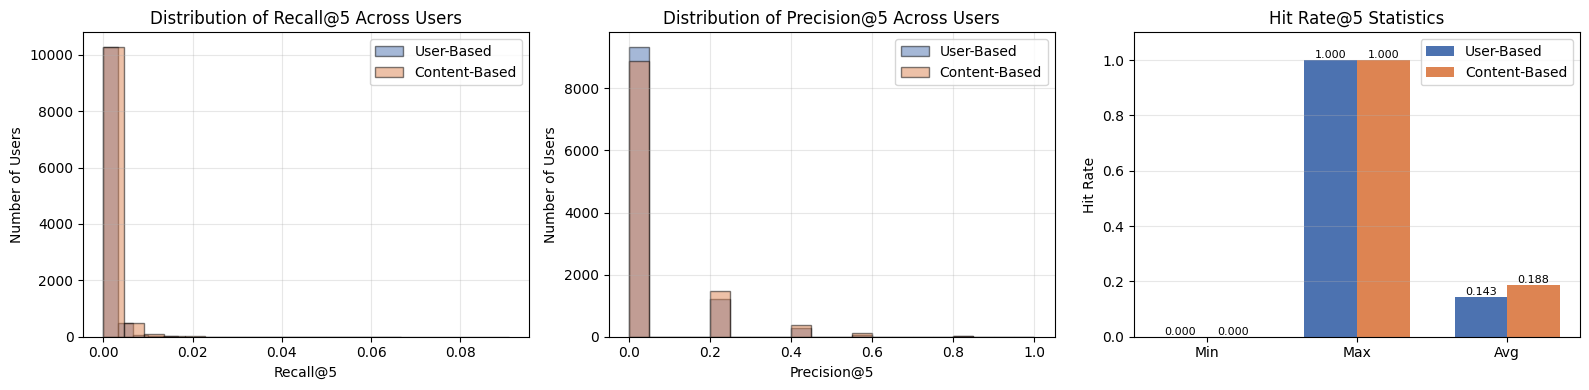

In [52]:
# Bar chart comparison
metrics_data = pd.DataFrame({
    'Metric': ['Recall', 'Precision', 'Hit Rate'],
    'User-Based': [avg_ub_recall, avg_ub_precision, ub_hit_rate],
    'Content-Based': [avg_cb_recall, avg_cb_precision, cb_hit_rate]
})

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(metrics_data['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_data['User-Based'], width, label='User-Based', color='#4C72B0')
bars2 = ax.bar(x + width/2, metrics_data['Content-Based'], width, label='Content-Based', color='#DD8452')

ax.set_ylabel('Score')
ax.set_title(f'Performance Metrics @ K={GLOBAL_K_VALUE}')
ax.set_xticks(x)
ax.set_xticklabels(metrics_data['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Distribution plots for individual user metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Recall distributions
axes[0].hist(ub_recalls, bins=20, alpha=0.5, label='User-Based', color='#4C72B0', edgecolor='black')
axes[0].hist(cb_recalls, bins=20, alpha=0.5, label='Content-Based', color='#DD8452', edgecolor='black')
axes[0].set_xlabel(f'Recall@{GLOBAL_K_VALUE}')
axes[0].set_ylabel('Number of Users')
axes[0].set_title(f'Distribution of Recall@{GLOBAL_K_VALUE} Across Users')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision distributions
axes[1].hist(ub_precisions, bins=20, alpha=0.5, label='User-Based', color='#4C72B0', edgecolor='black')
axes[1].hist(cb_precisions, bins=20, alpha=0.5, label='Content-Based', color='#DD8452', edgecolor='black')
axes[1].set_xlabel(f'Precision@{GLOBAL_K_VALUE}')
axes[1].set_ylabel('Number of Users')
axes[1].set_title(f'Distribution of Precision@{GLOBAL_K_VALUE} Across Users')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Hit rate as binary (0 or 1) per user
ub_hits = [1 if p > 0 else 0 for p in ub_precisions]
cb_hits = [1 if p > 0 else 0 for p in cb_precisions]

# Calculate statistics
ub_stats = {'min': min(ub_hits), 'max': max(ub_hits), 'avg': np.mean(ub_hits)}
cb_stats = {'min': min(cb_hits), 'max': max(cb_hits), 'avg': np.mean(cb_hits)}

# Create grouped bar chart for hit rate
categories = ['Min', 'Max', 'Avg']
ub_values = [ub_stats['min'], ub_stats['max'], ub_stats['avg']]
cb_values = [cb_stats['min'], cb_stats['max'], cb_stats['avg']]

x_pos = np.arange(len(categories))
width = 0.35

bars1 = axes[2].bar(x_pos - width/2, ub_values, width, label='User-Based', color='#4C72B0')
bars2 = axes[2].bar(x_pos + width/2, cb_values, width, label='Content-Based', color='#DD8452')

axes[2].set_ylabel('Hit Rate')
axes[2].set_title(f'Hit Rate@{GLOBAL_K_VALUE} Statistics')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(categories)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
